# **Blind source separation**
The purpose of the project is to separate an image obtained as a sum of a two images into its components. 

The two images img1 and img2 summed together come from different dataset: mnist and fashion_mnist, respectively.

No preprocessing is allowed. The network takes in input the sum img1+img2 and returns the predicted components hat_img1 and hat_img2. 

The metric used to evaluate the project is the mean squared error between predicted and ground truth images.


In [ ]:
import tensorflow as tf
from tensorflow import keras as ks
from tensorflow.keras import layers
from tensorflow.keras.datasets import mnist, fashion_mnist
import os
import numpy as np
from matplotlib import pyplot as plt

# **Data Loading**

Here we load the two datasets, mnist and fashion mnist (both in grayscale).

For simplicity, the samples are padded to dimension (32,32).

In [ ]:
(mnist_x_train, mnist_y_train), (mnist_x_test, mnist_y_test) = mnist.load_data()
print(np.shape(mnist_x_train))
(fashion_mnist_x_train, fashion_mnist_y_train), (fashion_mnist_x_test, fashion_mnist_y_test) = fashion_mnist.load_data()

#normalize in and pad
mnist_x_train = np.pad(mnist_x_train,((0,0),(2,2),(2,2)))/255.
print(np.shape(mnist_x_train))
mnist_x_test = np.pad(mnist_x_test,((0,0),(2,2),(2,2)))/255.
fashion_mnist_x_train = np.pad(fashion_mnist_x_train,((0,0),(2,2),(2,2)))/255.
fashion_mnist_x_test = np.pad(fashion_mnist_x_test,((0,0),(2,2),(2,2)))/255.


11501568/11490434 [==============================] - 0s 0us/step
(60000, 28, 28)
4431872/4422102 [==============================] - 0s 0us/step
(60000, 32, 32)


In [ ]:
print(np.shape(mnist_x_train))

(60000, 32, 32)


Here is a simple datagenerator.

In [ ]:
def datagenerator(x1,x2,batchsize):
    n1 = x1.shape[0]
    n2 = x2.shape[0]
    while True:
        num1 = np.random.randint(0, n1, batchsize)
        num2 = np.random.randint(0, n2, batchsize)

        x_data = (x1[num1] + x2[num2]) / 2.0
        y_data = np.concatenate((x1[num1], x2[num2]), axis=2)
        yield x_data, y_data 

Here we define three generators, one for training one for testing and one for validation. \\
For both training and validation datasets I defined $batchsize=64$.


In [ ]:
batchsize = 64
inputShape = (32,32,1)

In [ ]:
# training
train_generator = datagenerator(mnist_x_train,fashion_mnist_x_train, batchsize)
# validation
val_generator = datagenerator(mnist_x_test,fashion_mnist_x_test, batchsize)
# testing
samples = 20000
test_generator = datagenerator(mnist_x_test,fashion_mnist_x_test, samples)

Let us look at some input-output pairs

(64, 32, 32)


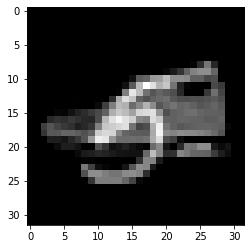

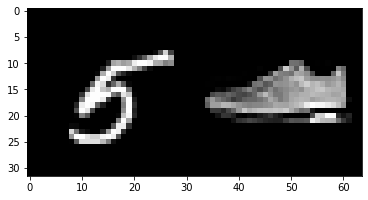

In [ ]:
x, y = next(train_generator)

print(np.shape(x))
plt.imshow(x[0],cmap='gray', interpolation='nearest')
plt.show()
plt.imshow(y[0], cmap='gray', interpolation='nearest')
plt.show()

# **Models**
---

## **Autoencoder** (not the best)
The first model that I tried is composed by **autoencoders**.

I started from the code of a standard autoencoder [[1]](https://github.com/animikhaich/Semantic-Segmentation-using-AutoEncoders) used for semantic segmentation and I modified it to obtain the desired output.

The input images is given to 2 differents autoencoders and each output is concatenated in the end.
![](https://drive.google.com/uc?export=view&id=1SAIBdF2eSG4I0PATX-NdVz9YlECzefRx)

Here I defined the function that build the model with autoencoder.

In [ ]:
def build_autoencoder(inputShape=(32,32,1)):
# encoding architecture
  inp = ks.layers.Input(shape=inputShape)

  ##1
  x1 = tf.keras.layers.Conv2D(64, (5, 5), activation='relu', padding='same')(inp)
  x2 = tf.keras.layers.Conv2D(64, (5, 5), activation='relu', padding='same')(x1)
  x3 = tf.keras.layers.MaxPool2D(padding='same')(x2)
  x4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x3)
  x5 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x4)
  x6 = tf.keras.layers.MaxPool2D(padding='same')(x5)
  encoded1 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same')(x6)
  # decoding architecture
  x7 = tf.keras.layers.UpSampling2D()(encoded1)
  x8 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x7)
  x9 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x8)
  x10 = tf.keras.layers.Add()([x5, x9])
  x11 = tf.keras.layers.UpSampling2D()(x10)
  x12 = tf.keras.layers.Conv2D(64, (5, 5), activation='relu', padding='same')(x11)
  x13 = tf.keras.layers.Conv2D(64, (5, 5), activation='relu', padding='same')(x12)
  x14 = tf.keras.layers.Add()([x2, x13])
  decoded1 = tf.keras.layers.Conv2D(1, (3, 3), padding='same',activation='relu')(x14)

  ##2
  z1 = tf.keras.layers.Conv2D(64, (5, 5), activation='relu', padding='same')(inp)
  z2 = tf.keras.layers.Conv2D(64, (5, 5), activation='relu', padding='same')(z1)
  z3 = tf.keras.layers.MaxPool2D(padding='same')(z2)
  z4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same')(z3)
  z5 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same')(z4)
  z6 = tf.keras.layers.MaxPool2D(padding='same')(z5)
  encoded2 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same')(z6)
  # decoding architecture
  z7 = tf.keras.layers.UpSampling2D()(encoded2)
  z8 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same')(z7)
  z9 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same')(z8)
  z10 = tf.keras.layers.Add()([z5, z9])
  z11 = tf.keras.layers.UpSampling2D()(z10)
  z12 = tf.keras.layers.Conv2D(64, (5, 5), activation='relu', padding='same')(z11)
  z13 = tf.keras.layers.Conv2D(64, (5, 5), activation='relu', padding='same')(z12)
  z14 = tf.keras.layers.Add()([z2, z13])
  decoded2 = tf.keras.layers.Conv2D(1, (3, 3), padding='same',activation='relu')(z14)

  #merge the output
  y = ks.layers.Concatenate(axis=2)([decoded1, decoded2])

  autoencoder = tf.keras.Model(inp, y)
  return autoencoder

Now I define and compile the model, it takes in input the dimension of the input images. \\
The optimizers used for the model is *Adam* with a learning rate equal to *1e-4*.

Model: "model_26"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_51 (InputLayer)          [(None, 32, 32, 1)]  0           []                               
                                                                                                  
 conv2d_431 (Conv2D)            (None, 32, 32, 64)   1664        ['input_51[0][0]']               
                                                                                                  
 conv2d_441 (Conv2D)            (None, 32, 32, 64)   1664        ['input_51[0][0]']               
                                                                                                  
 conv2d_432 (Conv2D)            (None, 32, 32, 64)   102464      ['conv2d_431[0][0]']             
                                                                                           

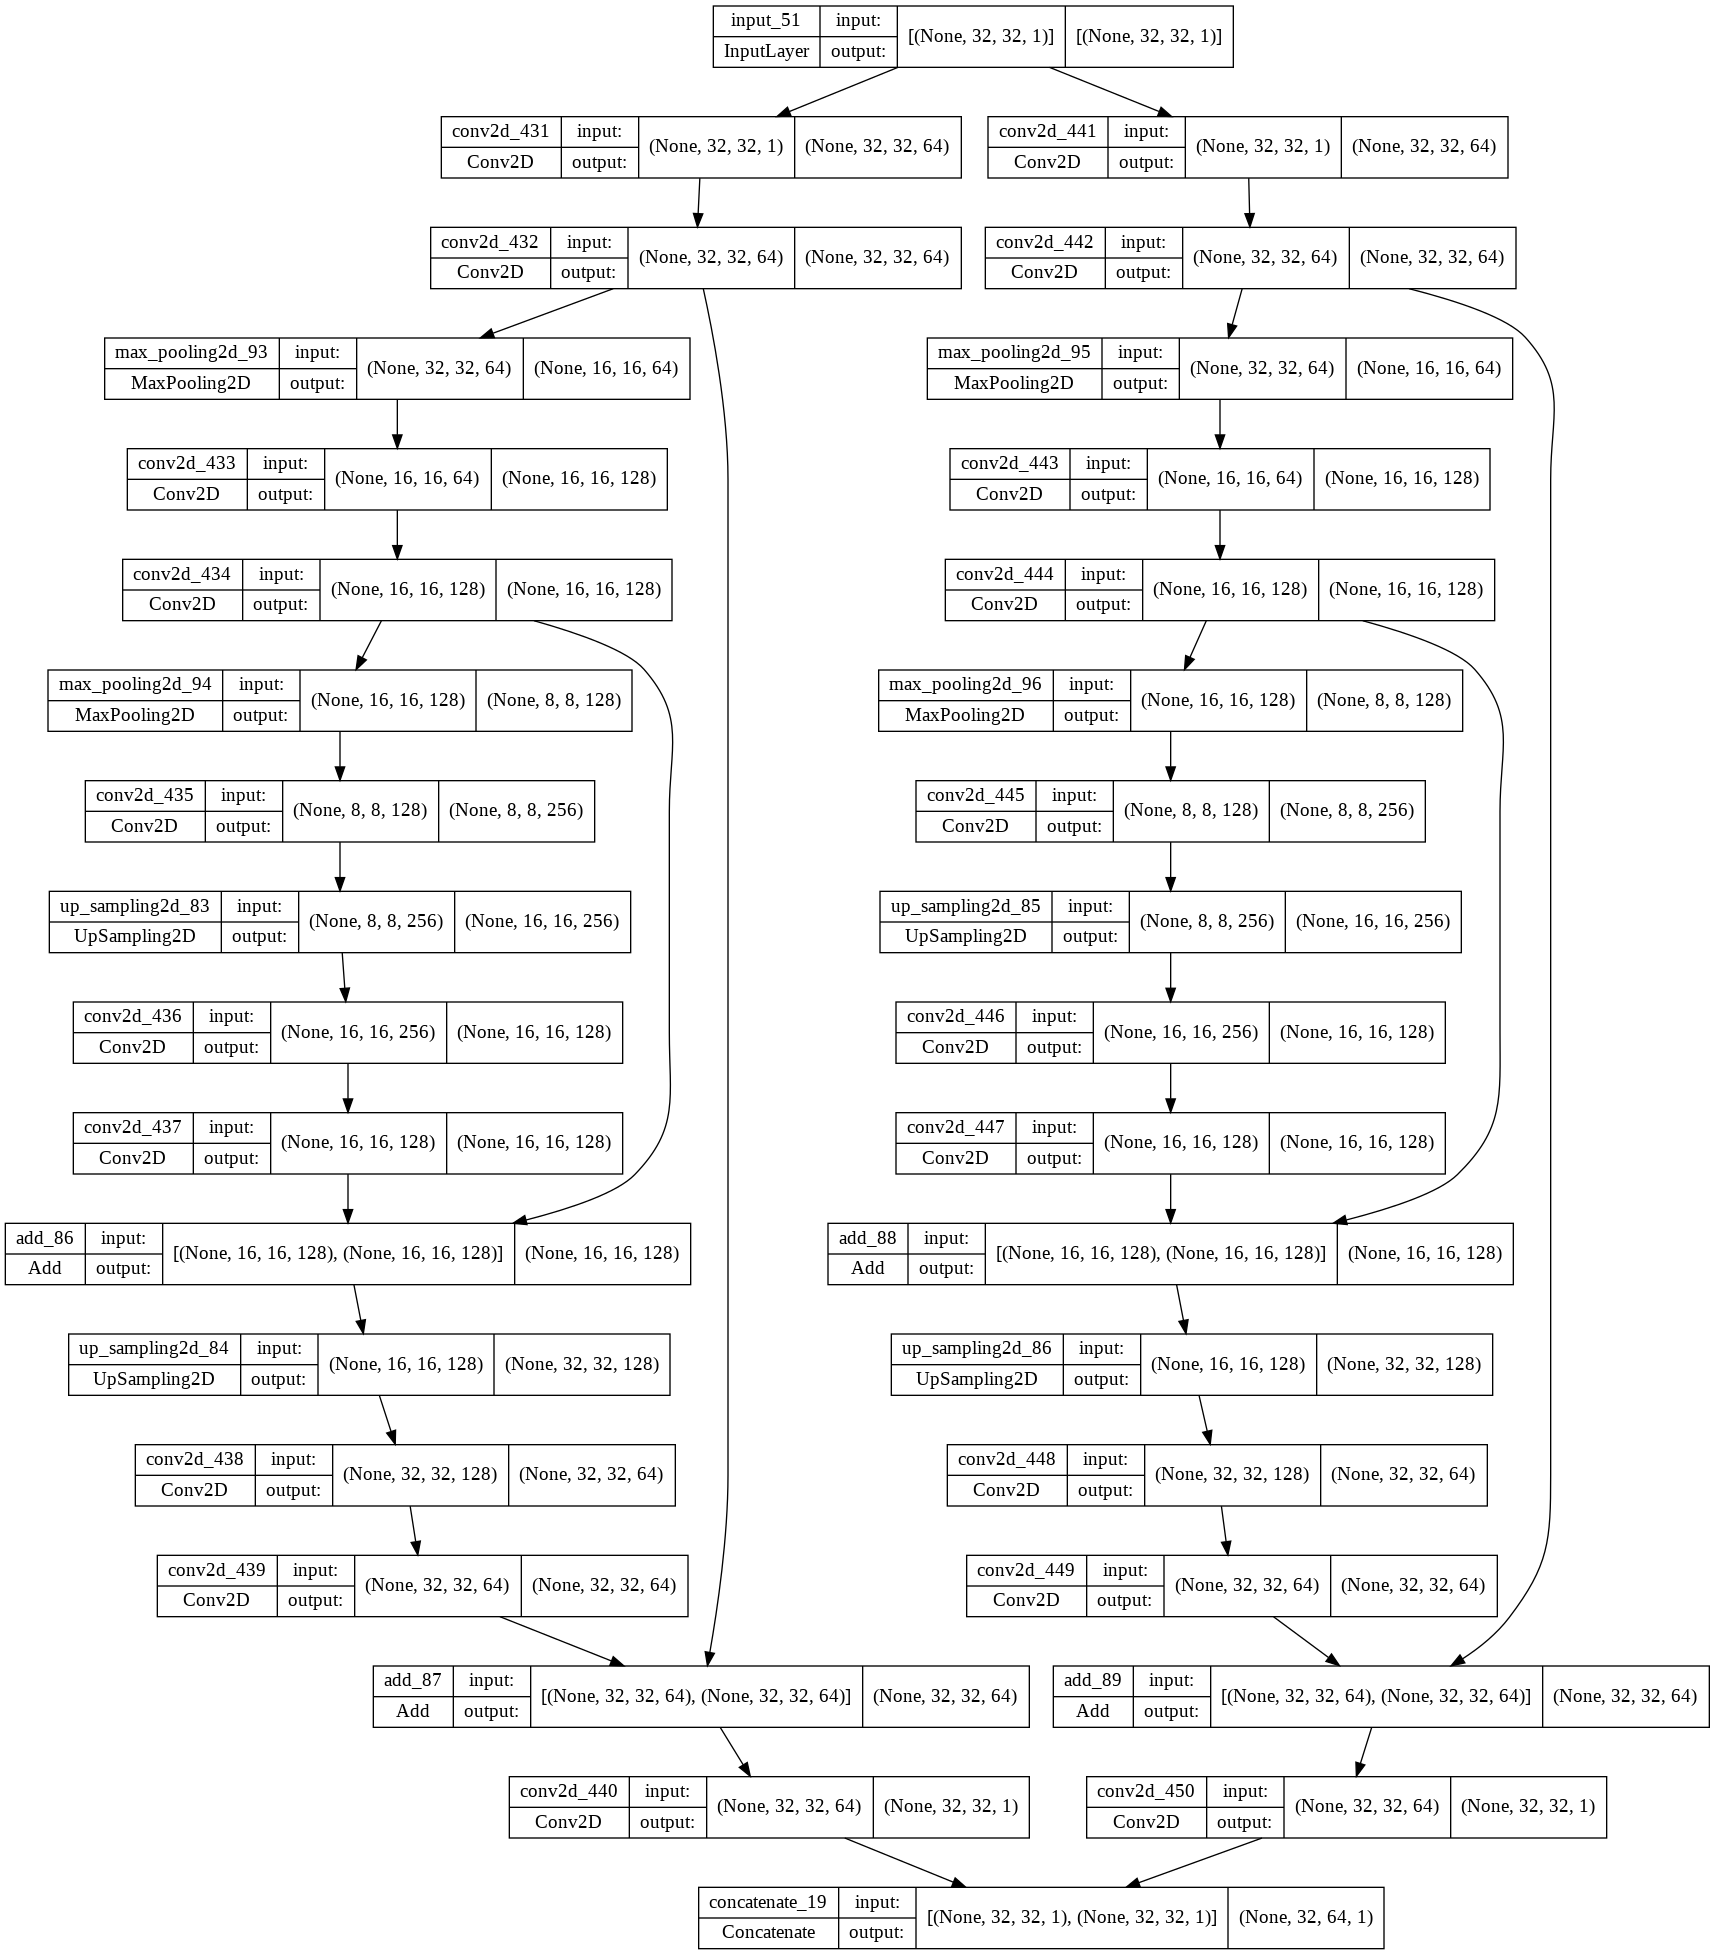

In [ ]:
lr = 1e-4
loss = 'mae'
metric = 'mse'

autoencoder = build_autoencoder(inputShape)
autoencoder.compile(optimizer=ks.optimizers.Adam(learning_rate=lr),
                  loss=loss,
                  metrics=[metric])

autoencoder.summary() # 2.7M params
ks.utils.plot_model(model=autoencoder, to_file='autoencoder.png', show_shapes=True)

The following cell contains the definition of the callbacks and of the number of images used to train the model. 

Since we use a generator that randomly overlaps an image from MNIST and one of Fashion-MNIST, the dataset contains up to $3600000000$ images for the training. 

We have a lot of images, so I decided to take advatage of it by using more data as possible for the training. 

The variable *dim* represents the number of batches used for each epoch, after some test I decided to assign to dim the value of $6000$. 

In this way the numbers of images used for each epoch is 
\begin{equation}
images = batchsize * dim = 64 * 6000 = 384000
\end{equation}

In [ ]:
dim = 6000

# Defining the callbacks
early_stopping_callback = ks.callbacks.EarlyStopping(monitor='val_mse', patience=2, verbose=1, mode='auto', restore_best_weights=True)
reduce_on_plateau_callback = ks.callbacks.ReduceLROnPlateau(monitor='loss', factor=0.5, patience=3, verbose=1, mode='auto')
# checkpoints every 2 epochs
checkpoint_path = "./checkpointAuto/cp-{epoch:04d}.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path,
    monitor="val_mse",
    save_weights_only=True,
    save_freq=dim*2)

callbacks = [early_stopping_callback, reduce_on_plateau_callback, cp_callback]

The following instruction starts the training of $10$ epochs.



In [ ]:
epochs = 10
histAuto = autoencoder.fit(train_generator, steps_per_epoch= dim, 
                      validation_data = val_generator, validation_steps = dim/10,
                      callbacks = callbacks,
                      epochs=epochs)

Epoch 1/10
6000/6000 [==============================] - 497s 83ms/step - loss: 0.0160 - mse: 0.0035 - val_loss: 0.0102 - val_mse: 0.0017 - lr: 1.0000e-04
Epoch 2/10
6000/6000 [==============================] - 500s 83ms/step - loss: 0.0092 - mse: 0.0015 - val_loss: 0.0083 - val_mse: 0.0013 - lr: 1.0000e-04
Epoch 3/10
6000/6000 [==============================] - 495s 83ms/step - loss: 0.0079 - mse: 0.0012 - val_loss: 0.0073 - val_mse: 0.0011 - lr: 1.0000e-04
Epoch 4/10
6000/6000 [==============================] - 499s 83ms/step - loss: 0.0072 - mse: 0.0010 - val_loss: 0.0068 - val_mse: 9.6126e-04 - lr: 1.0000e-04
Epoch 5/10
6000/6000 [==============================] - 499s 83ms/step - loss: 0.0067 - mse: 9.2766e-04 - val_loss: 0.0078 - val_mse: 9.5352e-04 - lr: 1.0000e-04
Epoch 6/10
6000/6000 [==============================] - 501s 83ms/step - loss: 0.0064 - mse: 8.6974e-04 - val_loss: 0.0062 - val_mse: 8.3926e-04 - lr: 1.0000e-04
Epoch 7/10
6000/6000 [==============================] - 

I defined a function that plots the **losses** and **mse**s over the time, to see if the model is overfitted.

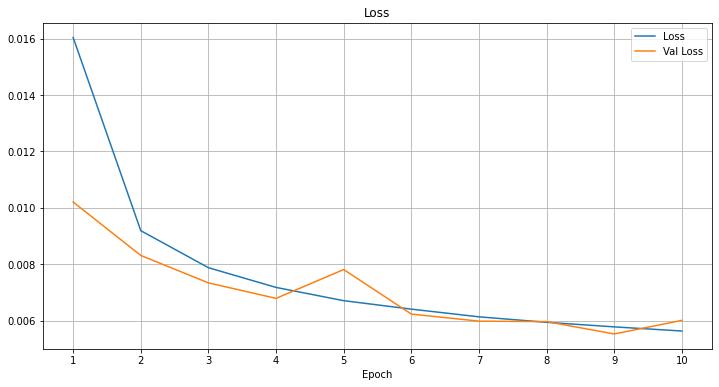

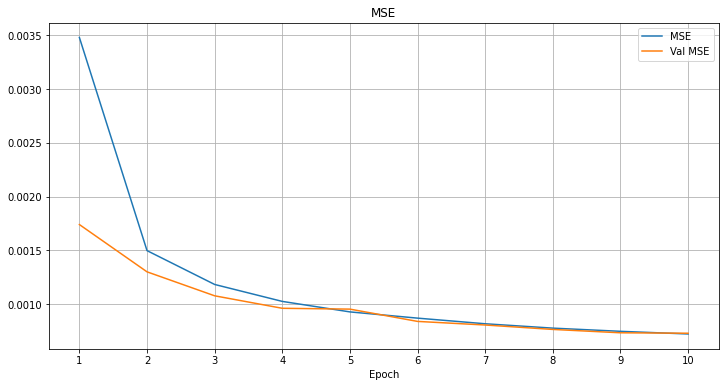

In [ ]:
def plot_history(hist, epochs):

    loss_history = hist.history['loss']
    val_loss_history = hist.history['val_loss']

    mse_history = hist.history['mse']
    val_mse_history = hist.history['val_mse']

    plt.rcParams['figure.figsize'] = [12, 6]
    plt.plot(range(1,epochs+1), loss_history)
    plt.plot(range(1,epochs+1), val_loss_history)
    plt.xticks(range(1,epochs+1))
    plt.grid()
    plt.xlabel('Epoch')
    plt.legend(['Loss', 'Val Loss'])
    plt.title('Loss')
    plt.show()

    plt.plot(range(1,epochs+1), mse_history)
    plt.plot(range(1,epochs+1), val_mse_history)
    plt.xticks(range(1,epochs+1))
    plt.grid()
    plt.xlabel('Epoch')
    plt.legend(['MSE', 'Val MSE'])
    plt.title('MSE')
    plt.show()

plot_history(histAuto,epochs)

We can see that the model is not overfitted. 

Now, as suggested by the text, I compute the **MSE** by computing the mean over 10 evaluations.

In [ ]:
def computeMSE(model, iterations):
  MSEs = []
  for i in range(iterations):
    x_test, y_test = next(test_generator)
    # x_test and y_test contain 20000 images, 
    # with batch_size=32 at each epoch the model evaluates 625 batches (625*32=20000)
    mse = model.evaluate(x_test, y_test, batch_size=32)[1]
    MSEs.append(mse)
  return MSEs

MSEs = computeMSE(autoencoder, 10)

625/625 [==============================] - 10s 16ms/step - loss: 0.0060 - mse: 7.3824e-04


Now we can print the results of the previous evaluation.

In [ ]:
print(f'Average MSE: {np.mean(MSEs):.6f}\nStandard deviation: {np.std(MSEs)}\nMinimum MSE: {min(MSEs)}')

Average MSE: 0.000728
Standard deviation: 5.657430917181563e-06
Minimum MSE: 0.0007182004046626389


Even if the average **MSE** looks good and the model can be improved performing a longer training session, I decided to look for other models that can give better results.

## **U-Net** (Best)
The best model that i found for image blind separation is a model composed by two parallel **U-Nets**.

Even if the previus model and this one look similar, the following model is far more complex. 

I started from a standard U-Net used for Image Segmentation and I modified it in the following way:


*   the input of dimension 32 x 32 is given to two different **U-Nets**;
*   for each floors I added a BatchNormalization layer between the Conv2D and the ReLu, as suggested in literature [[2]](https://ietresearch.onlinelibrary.wiley.com/doi/10.1049/ipr2.12531);
*   the outputs of the U-Nets is merged with a Concatenate layer.






In [ ]:
# The model is the one of the Lab4 with some changes.
def build_model(input_shape, n_ch=64, L=4, conv_per_L=2):
    # the number of channels is set to 64.
    
    x = ks.layers.Input(shape=input_shape)

    # FIRST UNET
    backup_layers1 = []
    h1 = x
    n_ch1 = n_ch
    for l in range(L):

        for c in range(conv_per_L):
            h1 = ks.layers.Conv2D(n_ch1, 3, 1, padding='same')(h1)
            h1 = tf.keras.layers.BatchNormalization(axis=1)(h1)
            h1 = ks.layers.ReLU()(h1)

        if l < L-1:
            backup_layers1.append(h1)
            h1 = ks.layers.MaxPool2D(padding='same')(h1)
            n_ch1 = n_ch1 * 2
    
    for l in range(L-1):
        n_ch1 = n_ch1 // 2
        h1 = ks.layers.Conv2DTranspose(n_ch1, 3, 2, padding='same')(h1)
        h1 = ks.layers.concatenate([h1, backup_layers1.pop(-1)])

        for c in range(conv_per_L):
            h1 = ks.layers.Conv2D(n_ch1, 3, 1, padding='same')(h1)
            h1 = tf.keras.layers.BatchNormalization(axis=1)(h1)
            h1 = ks.layers.ReLU()(h1)
    # Output 1
    y1 = ks.layers.Conv2D(1, 1, activation='sigmoid')(h1)

    # SECOND UNET
    backup_layers2 = []
    h2 = x
    n_ch2 = n_ch
    for l in range(L):

        for c in range(conv_per_L):
            h2 = ks.layers.Conv2D(n_ch2, 3, 1, padding='same')(h2)
            h2 = tf.keras.layers.BatchNormalization(axis=1)(h2)
            h2 = ks.layers.ReLU()(h2)

        if l < L-1:
            backup_layers2.append(h2)
            h2 = ks.layers.MaxPool2D(padding='same')(h2)
            n_ch2 = n_ch2 * 2
    
    for l in range(L-1):
        n_ch2 = n_ch2 // 2
        h2 = ks.layers.Conv2DTranspose(n_ch2, 3, 2, padding='same')(h2)
        h2 = ks.layers.concatenate([h2, backup_layers2.pop(-1)])

        for c in range(conv_per_L):
            h2 = ks.layers.Conv2D(n_ch2, 3, 1, padding='same')(h2)
            h2 = tf.keras.layers.BatchNormalization(axis=1)(h2)
            h2 = ks.layers.ReLU()(h2)
    # Output 2
    y2 = ks.layers.Conv2D(1, 1, activation='sigmoid')(h2)

    # Merge the outputs
    y = ks.layers.Concatenate(axis=2)([y1, y2])
    
    return ks.models.Model(x, y)

Now I define and compile the model, it takes in input the dimension of the input images. 

The optimizers used for the model is *Adam* with a learning rate equal to *1e-3*.

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 32, 32, 1)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 32, 32, 64)   640         ['input_1[0][0]']                
                                                                                                  
 conv2d_15 (Conv2D)             (None, 32, 32, 64)   640         ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 32, 32, 64)  128         ['conv2d[0][0]']                 
 alization)                                                                                   

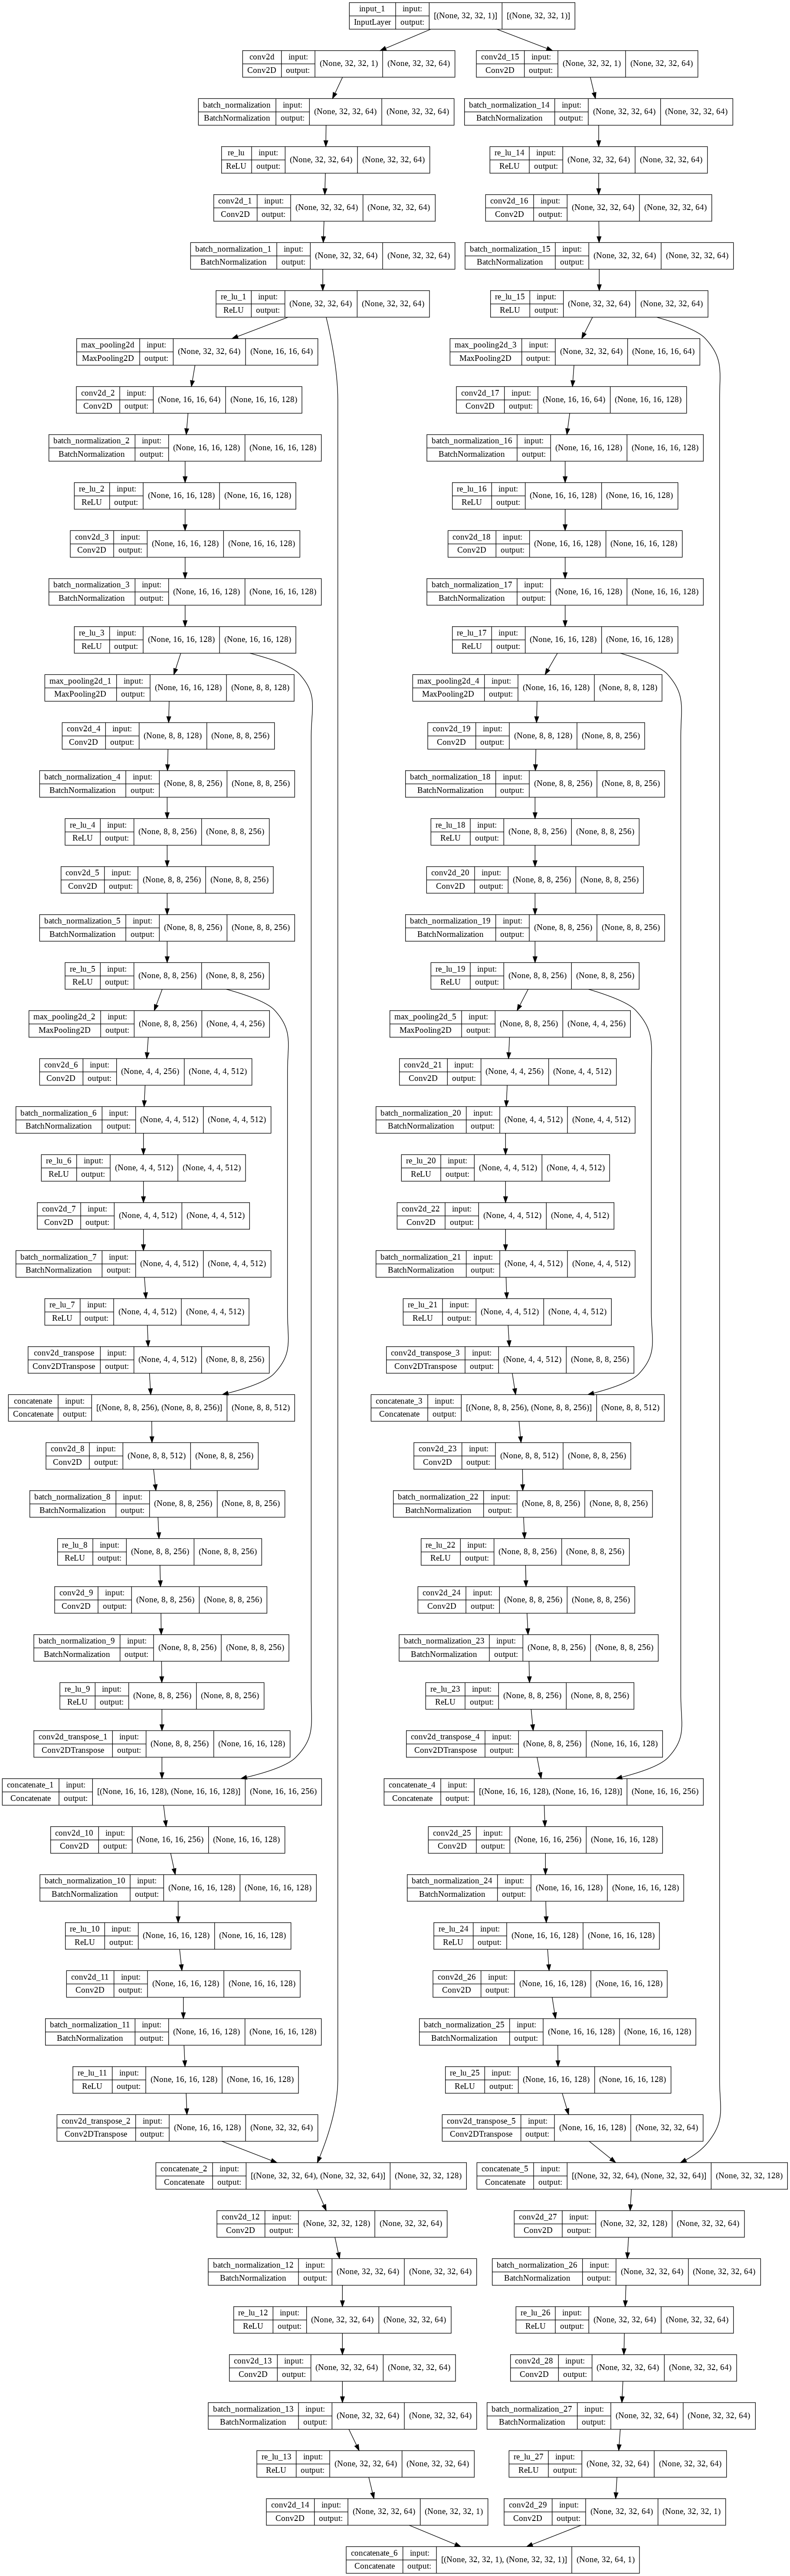

In [ ]:
lr = 1e-3
loss = 'mae'
metric = 'mse'

model = build_model(inputShape)
model.compile(optimizer=ks.optimizers.Adam(learning_rate=lr),
                  loss=loss,
                  metrics=metric)


print(model.summary()) # 17M params
ks.utils.plot_model(model=model, to_file='d_unet.png', show_shapes=True)

The following cell contains the instructions for the training. 

The code is very similar of the one of the previous model, I just changed some details (path of the checkpoints, patience etc.) 

In [ ]:
dim = 6000

# Defining the callbacks
early_stopping_callback = ks.callbacks.EarlyStopping(monitor='val_mse', patience=5, verbose=1, mode='auto', restore_best_weights=True)
reduce_on_plateau_callback = ks.callbacks.ReduceLROnPlateau(monitor='loss', factor=0.5, patience=3, verbose=1, mode='auto')
# checkpoints every 2 epochs
checkpoint_path = "./checkpointUnet/cp-{epoch:04d}.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path,
    monitor="val_mse",
    save_weights_only=True,
    save_freq=dim*2)

callbacks = [early_stopping_callback, reduce_on_plateau_callback, cp_callback]

I started with a training of 20 epochs. 

I saved the weights every 2 epochs since the training takes a long time and I didn't want to lose the progress.

In [ ]:
# Set hyperparameters
epochs = 20

# Training
hist1 = model.fit(train_generator, steps_per_epoch= dim, 
                      validation_data = val_generator, validation_steps = dim/10,
                      callbacks = callbacks,
                      epochs=epochs)

Epoch 1/20
6000/6000 [==============================] - 807s 133ms/step - loss: 0.0132 - mse: 0.0042 - val_loss: 0.0072 - val_mse: 8.4372e-04 - lr: 0.0010
Epoch 2/20
6000/6000 [==============================] - 806s 134ms/step - loss: 0.0060 - mse: 7.2683e-04 - val_loss: 0.0054 - val_mse: 6.4572e-04 - lr: 0.0010
Epoch 3/20
6000/6000 [==============================] - 804s 134ms/step - loss: 0.0052 - mse: 6.0223e-04 - val_loss: 0.0055 - val_mse: 5.8567e-04 - lr: 0.0010
Epoch 4/20
6000/6000 [==============================] - 803s 134ms/step - loss: 0.0049 - mse: 5.4874e-04 - val_loss: 0.0048 - val_mse: 5.3050e-04 - lr: 0.0010
Epoch 5/20
6000/6000 [==============================] - 802s 134ms/step - loss: 0.0046 - mse: 5.1257e-04 - val_loss: 0.0043 - val_mse: 4.9688e-04 - lr: 0.0010
Epoch 6/20
6000/6000 [==============================] - 803s 134ms/step - loss: 0.0045 - mse: 4.8982e-04 - val_loss: 0.0047 - val_mse: 5.0486e-04 - lr: 0.0010
Epoch 7/20
6000/6000 [============================

Now we can plot the **losses** and **mse**s over the time, to see if the model is overfitted.

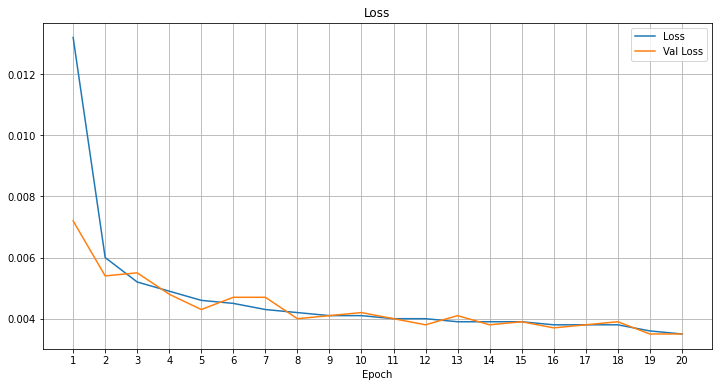

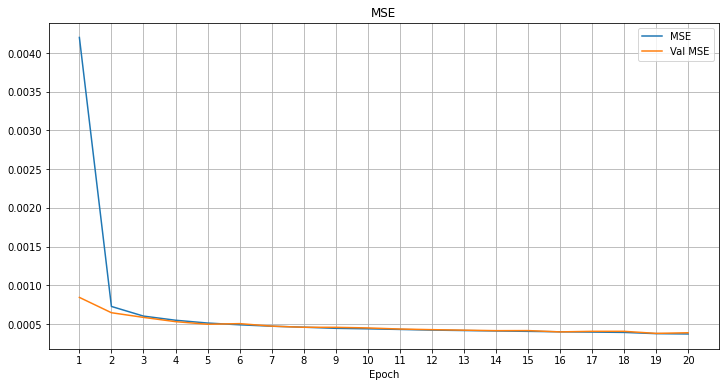

In [ ]:
plot_history(hist1, epochs)

We can see that the model is not overfitted and we already reached a good **mse**. 

Anyway, since both the **mse** and the **loss** on validation continue to decrease I decided to perform another training session.

In [ ]:
# Training
hist2 = model.fit(train_generator, steps_per_epoch= dim, 
                      validation_data = val_generator, validation_steps = dim/10,
                      callbacks = callbacks,
                      initial_epoch=epochs,
                      epochs=epochs*2)

Epoch 21/40
6000/6000 [==============================] - 810s 135ms/step - loss: 0.0035 - mse: 3.7035e-04 - val_loss: 0.0035 - val_mse: 3.7410e-04 - lr: 5.0000e-04
Epoch 22/40
6000/6000 [==============================] - 810s 135ms/step - loss: 0.0035 - mse: 3.6796e-04 - val_loss: 0.0035 - val_mse: 3.7656e-04 - lr: 5.0000e-04
Epoch 23/40
6000/6000 [==============================] - 809s 135ms/step - loss: 0.0035 - mse: 3.6525e-04 - val_loss: 0.0035 - val_mse: 3.7241e-04 - lr: 5.0000e-04
Epoch 24/40
6000/6000 [==============================] - ETA: 0s - loss: 0.0035 - mse: 3.6396e-04
Epoch 24: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
6000/6000 [==============================] - 810s 135ms/step - loss: 0.0035 - mse: 3.6396e-04 - val_loss: 0.0034 - val_mse: 3.7105e-04 - lr: 5.0000e-04
Epoch 25/40
6000/6000 [==============================] - 807s 134ms/step - loss: 0.0034 - mse: 3.5570e-04 - val_loss: 0.0034 - val_mse: 3.6655e-04 - lr: 2.5000e-04
Epoch 26/40
6000/

I plotted the history considering the whole training.

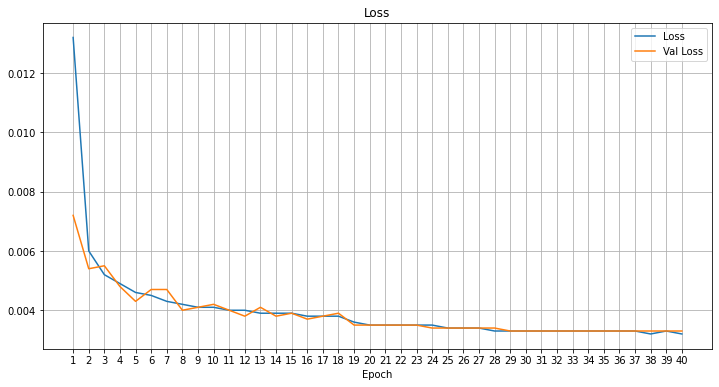

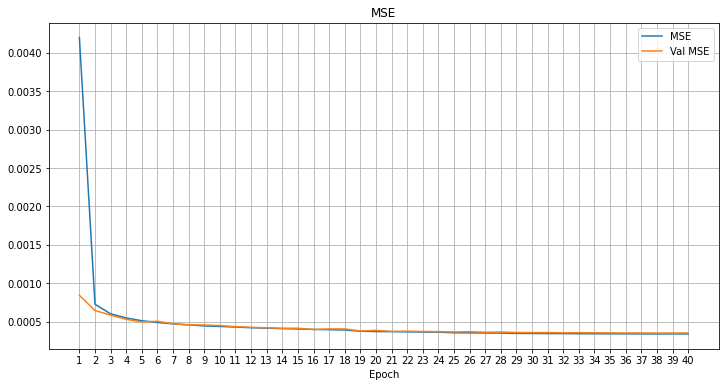

In [ ]:
hist = hist2    
    
hist.history['loss'] = hist1.history['loss'] + hist2.history['loss']
hist.history['val_loss'] = hist1.history['val_loss'] + hist2.history['val_loss']

hist.history['mse'] = hist1.history['mse'] + hist2.history['mse']
hist.history['val_mse'] = hist1.history['val_mse'] + hist2.history['val_mse']
    
plot_history(hist, epochs*2)

After 40 epochs the model is not overfitted. 

I decided to not continue with another training since the **loss** and the **mse** on the validation set seem to no longer decrease.

In the following cell we can see the results of the model by plotting some images. 

The **predictions** and the real images look very similar.

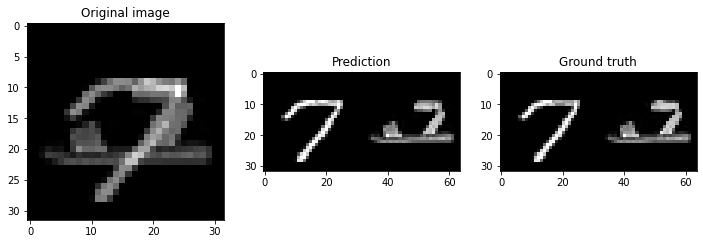

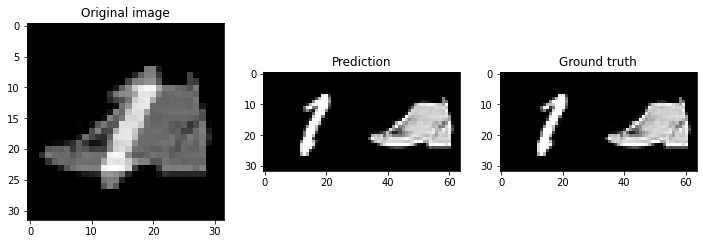

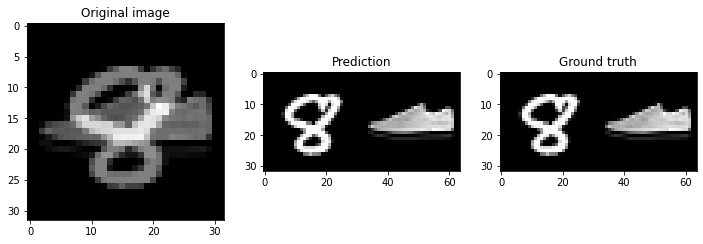

In [ ]:
# to generate a dataset of three elements
num = 3
tmp_generator = datagenerator(mnist_x_train,fashion_mnist_x_train, num)

x_tmp, y_tmp = next(tmp_generator)
pred_tmp = model.predict(x_tmp)

width = 12

for i in range(3):
  f, axarr = plt.subplots(nrows=1,ncols=3, figsize=(width,width))

  plt.sca(axarr[0])
  plt.imshow(x_tmp[i], cmap='gray', interpolation='nearest');plt.title('Original image')

  plt.sca(axarr[1])  
  plt.imshow(pred_tmp[i].reshape(32,64),cmap='gray', interpolation='nearest');plt.title('Prediction')

  plt.sca(axarr[2]) 
  plt.imshow(y_tmp[i], cmap='gray', interpolation='nearest');plt.title('Ground truth')

  plt.show()

Now, as suggested by the text, I compute the **MSE** by computing the mean over 10 evaluations.

In [ ]:
MSEs = computeMSE(model, 10)

625/625 [==============================] - 10s 15ms/step - loss: 0.0033 - mse: 3.4986e-04


We can see that the model obtained a very good results since over 10 epochs the average **mse** is **$0.000352$**

In [ ]:
print(f'Average MSE: {np.mean(MSEs):.6f}\nStandard deviation: {np.std(MSEs)}\nMinimum MSE: {min(MSEs)}')

Average MSE: 0.000352
Standard deviation: 1.841727099623387e-06
Minimum MSE: 0.00034935481380671263


Now we save the weights of the model as suggested by the text

In [ ]:
model.save_weights('model_weights.h5')

# **Conclusions**

I decided to use as best model the one with **U-nets**, even if it contains more parameters ($17M$ compared to $2.7M$). 

In fact we can see that after 2 epochs, we already obtained a better **mse** score. 


I also tried to use more difficult **U-Nets** looking at the implementations of **keras-unet-collection** [[3]](https://github.com/yingkaisha/keras-unet-collection) modifying them with the same strategies. In particular I tried to use **UNET 3+** and **Swin-UNET** but I obtained models with a very large number of parameters and, even if the performances were very similar to the ones that I obtained, the took a very long time (~30 min per epoch with the same dataset generator). I think that these models are too complex for our case, and another limitation is that they can't be used with their "$backbones$" (pretrained models such as VGG19, ResNet50, EfficientNetB7 etc.) since their are compatible only with 3-channels images but our dataset contains grey-scale images and we cannot preprocess the data.

Finally, the results that my model obtained are:
\begin{align}
  MSE_{mean} &= 0.000352 \\
  MSE_{min} &= 0.000349 \\
  SD &= 1.84172 e^{-06}
\end{align}